#  House Prices Prediction: Advanced Regression Techniques



## 1(A). house prices predictions raw data

In [392]:
import pandas as pd
import numpy as np
import statsmodels as sm
import statsmodels.formula.api as smf
from matplotlib import pyplot as plt

data_train = pd.read_csv('all/train.csv', index_col=0)
data_test = pd.read_csv('all/test.csv', index_col=0)

## 1(B). Build features from data

In [393]:
n_samples = len(data_train)
n_features = len(data_train.loc[1])
print('Length of data is: {}'.format(n_samples))
print('Number of feature: {}'.format(n_features))
print('\nCategorical variables include: ')

# categorical features are string type entry
cat_f=[]
for f in data_train.columns.values:
    if not data_train[f].dtype in ('float64', 'int64'):
        cat_f.append(f)
print (cat_f)
print ("total: {}".format(len(cat_f)))

Length of data is: 1460
Number of feature: 80

Categorical variables include: 
['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
total: 43


## 1 (C) Important variables and their scatterplot matrix 

From our observation, these variables seem to be important: 
Year of sale, Garage area, Neighborhood, House style, Year of built, Lot area, 1st Floor Square Feet, Foundation, Exterior Cover on the House, Full Bathroom, and Bedroom Above Ground.

Among the important variables, these ones seem to correlate to the house prices: 
Garage Area,Year of Sale, Lot Area, Neighborhood, Full Bathroom, Bedroom Above Ground, and House style

The seven variables We chose are Garage Area,Year of Sale, Lot Area, Pool Area, Full Bathroom, Bedroom Above Ground, Fireplaces


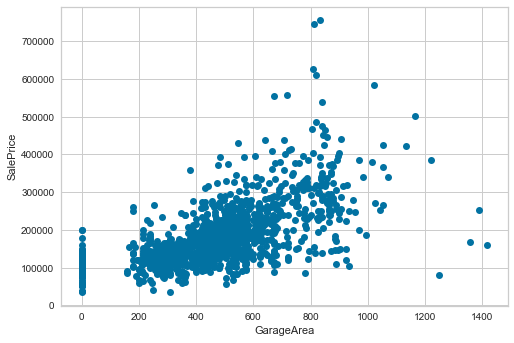

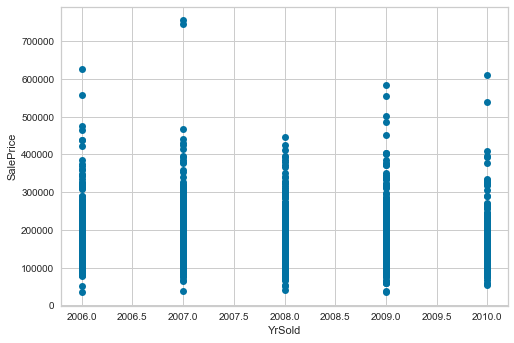

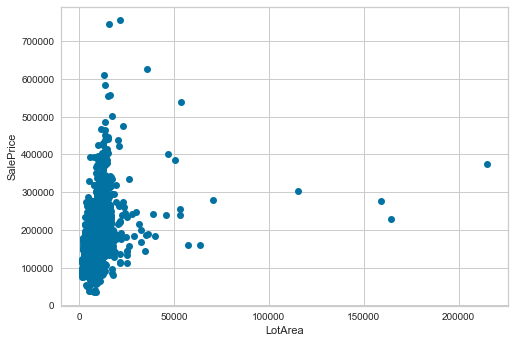

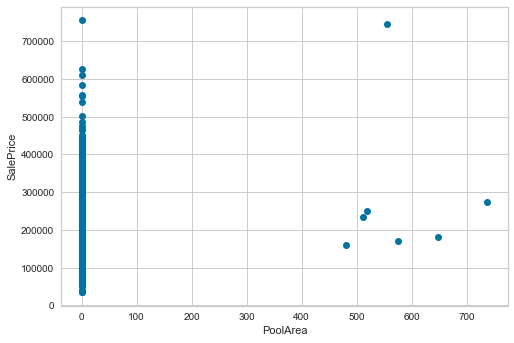

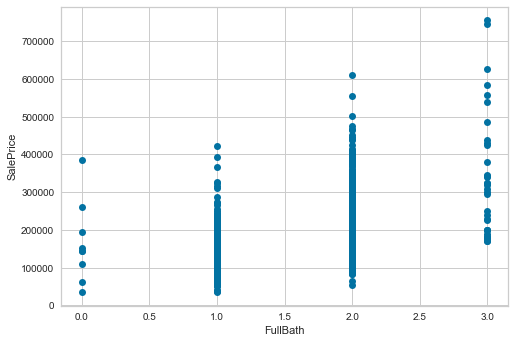

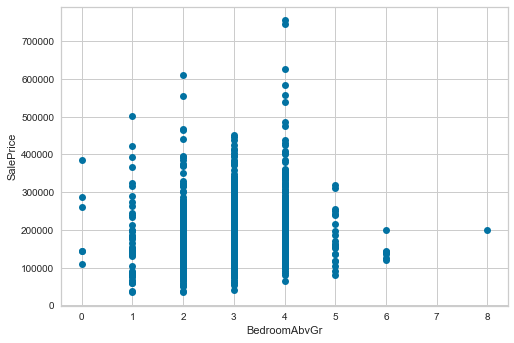

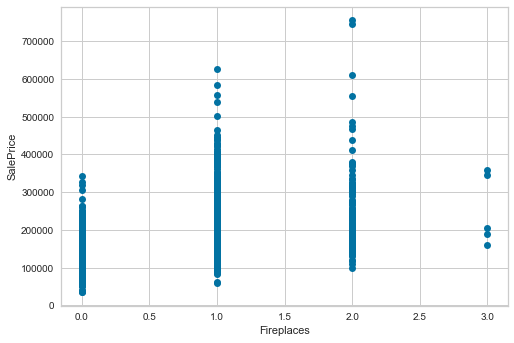

In [255]:
print('From our observation, these variables seem to be important: \nYear of sale, Garage area, Neighborhood, House style, \
Year of built, Lot area, 1st Floor Square Feet, Foundation, Exterior Cover on the House, Full Bathroom, and Bedroom Above Ground.')

print('\nAmong the important variables, these ones seem to correlate to the house prices: \nGarage Area,\
Year of Sale, Lot Area, Neighborhood, Full Bathroom, Bedroom Above Ground, and House style')

print('\nThe seven variables We chose are Garage Area,Year of Sale, Lot Area, Pool Area, \
Full Bathroom, Bedroom Above Ground, Fireplaces')

features = ['GarageArea', 'YrSold', 'LotArea', 'PoolArea', 'FullBath', 'BedroomAbvGr', 'Fireplaces']
for i,f in enumerate(features):
    plt.plot(data_train[f], data_train['SalePrice'], 'o')
    plt.xlabel(f)
    plt.ylabel('SalePrice')
    plt.show()



['GarageArea', 'YrSold', 'LotArea', 'PoolArea', 'FullBath', 'BedroomAbvGr', 'Fireplaces', 'SalePrice']


Observations: 
from the scatterplots, we noticed that pool area does not have an obvious correlation with sales price
mainly because there are too many houses without a pool. Other chosen features more or less changes with sales 
prices. However, there are not obvious correlations between each features except for a few pairs such as Bedroom
above ground and Full Bath. This is good because we want features from as different angles as possible to predict
our sales prices.




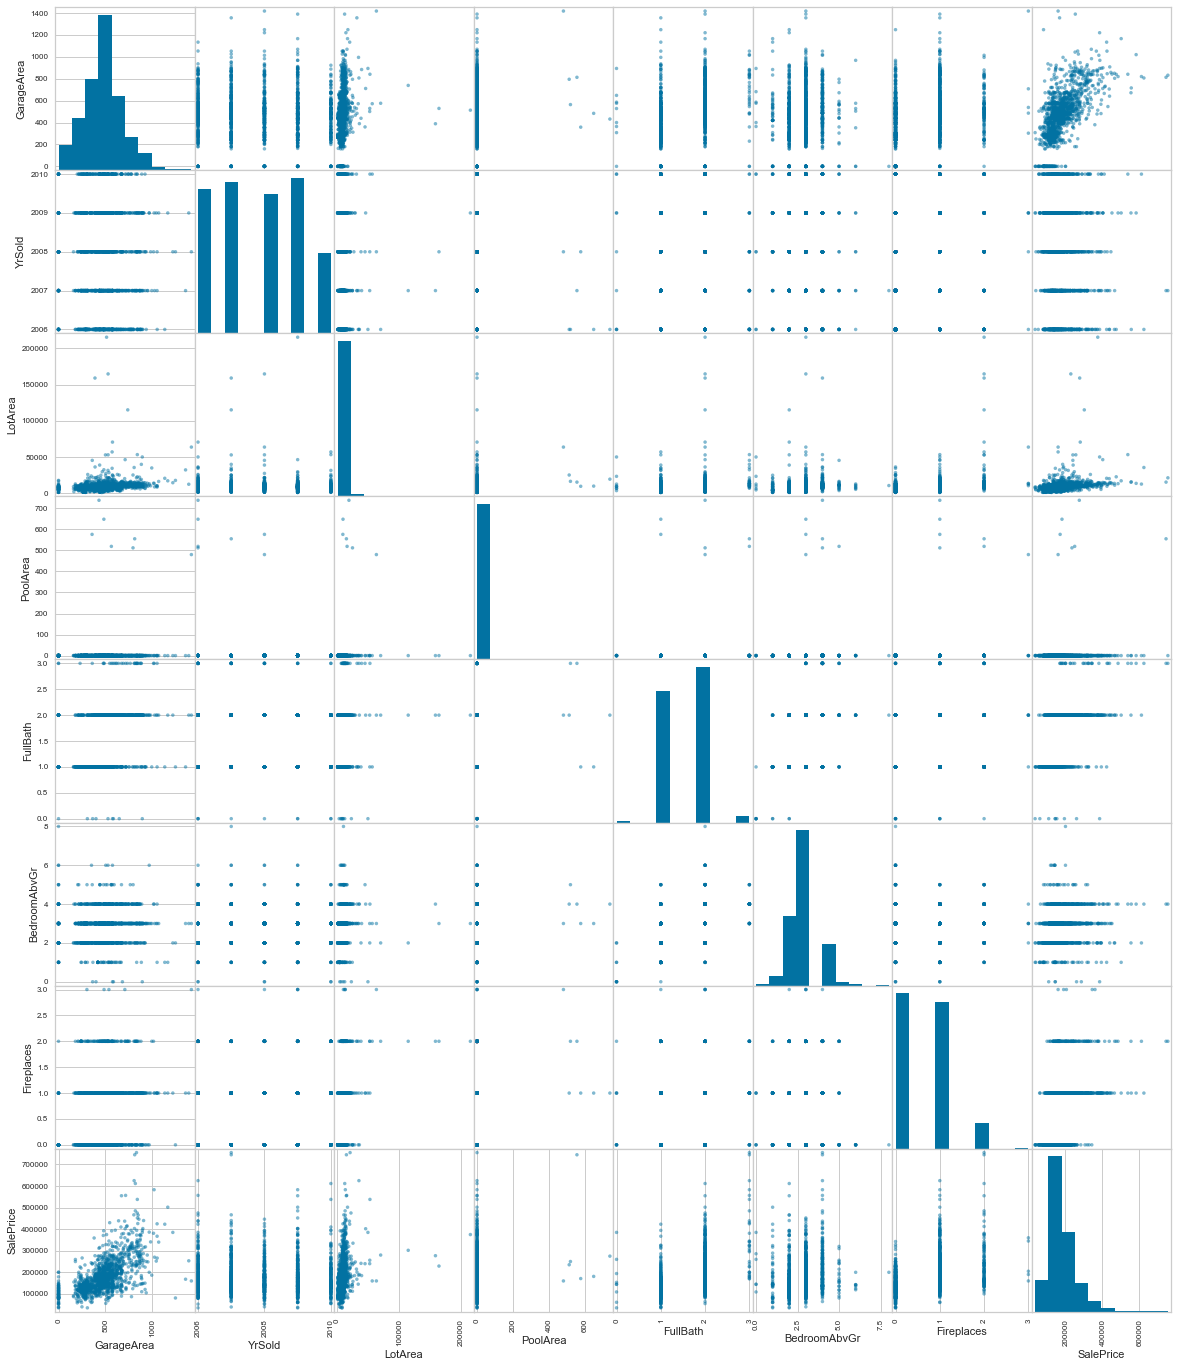

In [268]:
features_with_target = features + ['SalePrice']
print(features_with_target)
print ("\n\nObservations: \nfrom the scatterplots, we noticed that pool area does not have an obvious correlation with sales price\
\nmainly because there are too many houses without a pool. Other chosen features more or less changes with sales \
\nprices. However, there are not obvious correlations between each features except for a few pairs such as Bedroom\
\nabove ground and Full Bath. This is good because we want features from as different angles as possible to predict\
\nour sales prices.\n\n")
pd.plotting.scatter_matrix(data_train[features_with_target], figsize=(20, 24))
plt.show()

  

 ------------------------------------
 ## 1(D). Train OLS model  

In [206]:
from utils.cv_report import cv_report, cv_plot
from utils.test_report import test_report
from models.ols_run_and_test import ols_run_and_test

##### build training datasets

In [760]:
import statsmodels.api as sm
import patsy
from sklearn import preprocessing as prep

# Raw data preprocessing
def preprocessing(x, cat_f):
    """data preprocessing, add numerical and add categorical with one hot, both standardize within each feature
    missing values are replaced with mean for numerical and as a new "unknown" class for categorical 
    
    method takes dataframe and return data as numpy.
    Args: 
       X: data dataframe
       cat_f: list of categorical variable names"""
    name_space = []
    n_samples = x.shape[0]
    X = np.array(prep.scale(x[data_train.columns.values[0]], axis=0)).reshape(n_samples,-1)
    name_space.append(data_train.columns.values[0])
    for f in data_train.columns.values[1:-1]:   
        # categorical t
        if f in cat_f:  
            # one hot
            one_hot=sm.tools.categorical(x[f].fillna('unknown').values, drop=True).reshape(n_samples,-1)  # shape (1460, n_class)
            # standardize
            one_hot_stdr = prep.scale(one_hot, axis=0)    # independently standardize each feature, shape (1460, n_class)
            X = np.append(X, one_hot_stdr, axis=1)
            for i in range(one_hot.shape[1]):
                name_space.append(f+'_'+str(i))
        # numerical
        else:     
            x_ = x[f].replace(np.NaN, x[f].mean()).values
            x_srdr = prep.scale(x_, axis=0)
            X = np.insert(X, -1, x_srdr, axis=1)
            name_space.append(f) 
    return X, name_space

def numpy2dataframe(X, Y, name_space):
    """
    Args: 
        X: training data numpy, shape (n_sample, n_features)
        Y: label (target) numpy, shape (n_sample, 1) or (n_sample, )
        name_space: list of all training features
    Return:
        df:　dataframe with all X and Y as y column added in df
        r_formula: fit formula for statsmodel, as 'y~ all x in name_space'       
    """
    # write as dataframe  
    dataframe = {f:X[:,i] for i, f in enumerate(name_space)}
    dataframe['y']=Y.reshape(-1)
    df = pd.DataFrame(dataframe, index=[i for i in range(n_samples)])
    r_formula = 'y~'+'+'.join([f for f in name_space])
    
    return r_formula, df


X, name_space, = preprocessing(data_train, cat_f)
n_samples, n_features_t = X.shape

# add constant and rewrite name_space
X = sm.add_constant(X)    
name_space.insert(0, "constant")
Y = data_train["SalePrice"].values.reshape(n_samples,1)

print ("Datasets Built from raw.")
print ("have shape: {}".format(X.shape))

r_formula, df = numpy2dataframe(X, Y, name_space)

Datasets Built from raw.
have shape: (1460, 305)


In [264]:
print ("We handled the missing values and did pre-processing as:\n   Categorical: treated as a seperate class 'unknown', \n                then we use one-hot for categorical variables and standardize data on each column\n   Numerical:   standardize data, and replace missing value by mean of the feature")
print ("\n   label with an integer tail below, like MSZoning_0, MSZoning_1, MSZoning_3, MSZoning_4, \
        \n   is made from one-hot to encode categorical features.\
        \n----------------------------------------------------------")        
# Train OLS Model  
r_formula, df = numpy2dataframe(X, Y, name_space)
model = smf.ols(r_formula, df).fit() 
# Get Summary
sy = model.summary()

f1, f2 = [], []
f1_short, f2_short = set(), set()  
conf = model.conf_int()  # 95% confidence interval 
for idx, (lo, hi) in enumerate(conf.values): 
    if lo <= 0 <= hi: 
        f1.append(idx)  # 95%CI contained zero
    else: 
        f2.append(idx)
f1 = conf.iloc[f1].index.tolist()
f2 = conf.iloc[f2].index.tolist()
for x in f1: 
    if "_" in list(x): x = x[:x.index("_")]
    f1_short.add(x)
for x in f2: 
    if "_" in list(x): x = x[:x.index("_")]
    f2_short.add(x)
print ("\nModel Trained. \
        \nAccording to trained features' coefficient, we found that:")
print  ("\nFeatures(omitting the one-hot effect) that have 95%CI of containing 0, are:\n\n{}     (total{})\n\nOthers that have 95%CI of not containing 0 are:\n\n{}      (total{})".format(f1_short, len(f1_short),f2_short, len(f2_short)))


print ("\n\nANALYSIS: \n----------\n")
print ("The group of features that have 95%CI of containing 0 indicates thse features have a higher proabability of contibuting zero\
\nto the model parameters, therefore are less significant, making a smaller contribution to the parameters and could be dropped \
when reducing the size the features. Whereas, the second group of features with 95% confidence interval that doesn't hit 0\
\nvalue yet, i.e.has p-value of < 0.05, indicates a smaller probability of predicting a zero value for model parameter and \
\nmake more contribution in prediction.")



Constructed training data for model, Done.
shape: n_sample, n_features = (1460, 305)


We handled the missing values and did pre-processing as:
   Categorical: treated as a seperate class 'unknown', 
                then we use one-hot for categorical variables and standardize data on each column
   Numerical:   standardize data, and replace missing value by mean of the feature

   label with an integer tail below, like MSZoning_0, MSZoning_1, MSZoning_3, MSZoning_4,         
   is made from one-hot to encode categorical features.        
----------------------------------------------------------

Model Trained.         
According to trained features' coefficient, we found that:

Features(omitting the one-hot effect) that have 95%CI of containing 0, are:

{'Alley', 'ExterCond', 'BsmtCond', 'Exterior1st', 'PoolQC', 'MSSubClass', 'CentralAir', 'GrLivArea', 'LotConfig', 'KitchenAbvGr', 'GarageFinish', 'PoolArea', 'GarageType', 'Exterior2nd', 'SaleType', 'LotArea', 'SaleCondition', 'YrSold

 ------------------------------------
 ## 1(E). Various Regression Model (Model / Feature Selection)
-  OLS     
-  KNN with 10-fold CV to choose k
1. Ridge with 10-fold CV to choose lambda
1. LASSO with 10-fold CV to choose lambda
1. BSR with 10-fold to choose k (# features)
1. FSR with 10-fold to choose k (# features)

In [176]:
from sklearn.model_selection import train_test_split

# Split train data into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=False) 
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

a, _ = X_train.shape
b, _ = X_test.shape
# To dataframe
r_formula, X_train_frame = numpy2dataframe(X_train, y_train, name_space)
X_test_frame = pd.DataFrame.from_dict({f:X_test[:,i] for i, f in enumerate(name_space)})

print ("Splitted original datasets done, into\ntrain dataset: {}, {}\ntest dataset: {}, {}".format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))

Splitted original datasets done, into
train dataset: (1168, 305), (1168,)
test dataset: (292, 305), (292,)


### 1. OLS.

In [791]:
import statsmodels.formula.api as smf
# Train  
olsmodel = smf.ols(r_formula, X_train_frame).fit() 
sy_1e_ols = olsmodel.summary()

# Test
print ("                  REPORT\n======== Ordinary Least Squares OLS  =====\n              (all features) \n============================================")
y_pred_ols = olsmodel.predict(X_test_frame)
test_report(y_pred_ols, y_test)
print ("\nAnalysis: It was found that OLS is a good approach to predict\
       \n the house prices given the 305 number of features.\n")

print ("Observation: we found that standardizing the training data (within each feature) \nBOOSTED the test accuracy by > 2%. ")


                  REPORT
======== Ordinary Least Squares OLS  =====
              (all features) 
Test Accurracy
mse: 2144582497.841697
r2: 68.0169%


Analysis: It was found that OLS is a good approach to predict       
 the house prices given the 305 number of features.

Observation: we found that standardizing the training data (within each feature) 
BOOSTED the test accuracy by > 2%. 


### 2. KNN.

In [271]:
from models.knnCV import knnCV
from sklearn.neighbors import KNeighborsClassifier

scale = range(1,151,2)
cv_scores_knn = knnCV(X_train, y_train, scale, cv=10)
print ("KNN trained on k = 1, 3, 5,...150 with cross validation")

KNN trained on k = 1, 3, 5,...150 with cross validation



                   CV Score Report (knn):
k = 1 has the smallest CV score of:
 mean                std
-1319561080.4033463,  298252265.61254334

Among all k reporting a score within 1 SE of the 
smallest score(-1617813346.0158896, -1021308814.790803),
we choose the simplest model as a better model. 

all k that qualifies
k    cv score   std
1:   -1319561080.40334 | 298252265.61254 |
3:   -1412100705.60452 | 468001397.73418 |


We could risk a simpler model, i.e. pick better k = 3 with cv score of -1412100705.6045284
------------------------------------------------------------
Below plots the CV error against parameter k, and mark

min:    1, with score -1319561080.4033463
better: 3, with score -1412100705.6045284


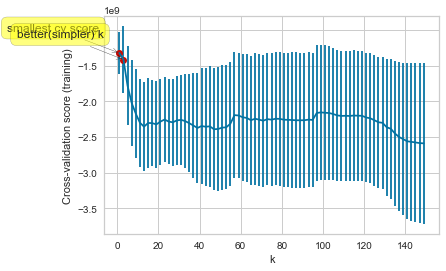


                      REPORT
 ============ K-Nearest-Neighbor KNN  ===========
                (all features,k=3) 
tested the best model on the test set

Test Accurracy
mse: 3462619536.527397
r2: 48.3604%

Analysis:
--------------------------------
The results showed that the model fits the data very poorly, with a r2 score of 48.360%.       

Also, the chosen k values that found to performed the best are actually very small,       
using only 1 or 3 out of the total 305 features as the "nearest neighbors" to predict        
the house price of interest. This can make the best-fit line very sensitive to outliers and       
to a very specific feature value, such as the garage type or the area of the frist floor.       
This usually doesn't lead to accurate predictions. However, increasing the value of k paramter        
was found to be not improving the prediction at all in the figure above.       

Therefore, the early stage of experiment led to the conclusion that using the model KNN 

In [404]:
# report cv scores
best_k_knn, __, min_k_knn, __ = cv_report(cv_scores_knn, scale, "k", name="knn")
    
# TEST
print ("\n                      REPORT\n ============ K-Nearest-Neighbor KNN  ===========\n                (all features,k={}) \n".format(best_k)+"="*55)
print("tested the best model on the test set\n")
knnmodel = KNeighborsClassifier(n_neighbors=min_k_knn)
knnmodel.fit(X_train, y_train) 
y_pred_knn = knnmodel.predict(X_test)

# report test accuracy
acc_knn, r_knn = test_report(y_pred_knn, y_test)

# ANALYSIS
print ("Analysis:\n--------------------------------")
print ("The results showed that the model fits the data very poorly, with a r2 score of {}%.\
       \n\nAlso, the chosen k values that found to performed the best are actually very small,\
       \nusing only {} or {} out of the total 305 features as the \"nearest neighbors\" to predict \
       \nthe house price of interest. This can make the best-fit line very sensitive to outliers and\
       \nto a very specific feature value, such as the garage type or the area of the frist floor.\
       \nThis usually doesn't lead to accurate predictions. However, increasing the value of k paramter \
       \nwas found to be not improving the prediction at all in the figure above.\
       \n\nTherefore, the early stage of experiment led to the conclusion that using the model KNN (with k = {}) \
       \non all features given is a bad approach to tackle this prediction problem.".format(str(r_knn*100)[:6], min_k_knn, best_k_knn, min_k_knn))


### 3. Ridge and Lasso.

In [376]:
from models.ridge_lasso_CV import ridgeCV, lassoCV
scale = lambds = np.logspace(-1, 3.3, 100)   # 100 lambdas to try

__, scores_r = ridgeCV(X_train, y_train, scale)
model_l, scores_l = lassoCV(X_train, y_train, scale)
print ("Ridge and Lasso trained.")

Ridge and Lasso trained.


In [454]:
def featuer_retain_analysis(name, name_all, retained_all):
    """get what features are retained or regularized away.
    get both full version and the one ommiting one-hot effects"""
    dropped_ = set()
    dropped_all = set(name_all) - set(retained_all)
    for x in dropped_all:  # omitting one-hot effects and create concise list of names 
        if "_" in list(x):
            x = x[:x.index("_")]
        dropped_.add(x)
    retained_ = set(name) - dropped_
    
    return retained_, retained_all, dropped_, dropped_all


                                        REPORT
 ====================     Ridge and Lasso Regression  ====================
                        (all features,lambda=see below) 
For ridge, to obtain a simpler model, we could pick lambda as 1805.36, 
wwithin 1 SE range 
of the model with smallest cv score at lambda 402.7


For lasso, to obtain a simpler model, we could pick lambda as 1995.26, 
wwithin 1 SE range 
of the model with smallest cv score at lambda 600.8



Figure below draws cv scores (using MSE) against lambdas on Ridge and Lasso using 
10-fold cv.


<Figure size 288x216 with 0 Axes>

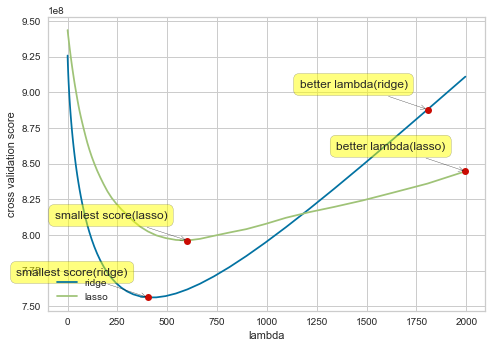




Test the best model selected, Ridge and Lasso:
ridge (lambda:402.76)
Test Accurracy
mse: 1855244517.3400059
r2: 72.3319%

lasso (lambda:600.88)
Test Accurracy
mse: 1876231356.1545827
r2: 72.0189%

Performance Analysis:
----------------------------
It is observered that both Ridge and LASSO both outperformed KNN and OLS approach by a 
large margin ~4% in test accuracy. In the figure above, it was interesting to observe that Ridge 
showed a lower mse loss at minimum and before lambda grows beyond ~1200. However, at a large lambda 
value > 1200, Lasso showed a better performance while the loss of Ridge goes up rapidly. However, 
Ridge beat Lasso by its best performance at lambda=72.01



The features being regularized away by Lasso at its best model were:
(if we say one class of a category is dropped, the whole category feature is dropped)

{'Alley', 'ExterCond', 'BsmtCond', 'Exterior1st', 'PoolQC', 'CentralAir', 'KitchenAbvGr', 'LotConfig', 'GarageFinish', 'PoolArea', 'SaleType', 'Ext

In [476]:
# Report the best lambda and plot 
print (" "*40+"REPORT\n "+"="*20+"     Ridge and Lasso Regression  "+"="*20+"\n"+" "*24+"(all features,lambda={}) \n".format("see below")+"="*88)
scale = lambds = np.logspace(-1, 3.3, 100)
plt.figure(figsize=(4, 3))
best_lambda, min_lambda = {}, {}
cv_scores_r_l = [scores_r, scores_l]
plt.figure(figsize=(7,5))

for name, cv_sc in {"ridge": cv_scores_r_l[0], "lasso": cv_scores_r_l[1]}.items():
    x_axis = lambds if name=="ridge" else model_l.alphas_ # seems like lasso doesn't use lambda value directly. need to call alphas_ for fitting parameter 
    
    best_k, best_cv, min_k, min_cv = cv_report(cv_sc, x_axis, param = "lambda("+name+")", display=False, plot=False, name=name)
    best_lambda[name], min_lambda[name] = best_k, min_k 
    plt.plot(x_axis, np.array(cv_sc)[:,0], label=name)
    
    print ("For "+name+", to obtain a simpler model, we could pick lambda as "+str(best_k)[:7]+", \nwwithin 1 SE range \nof the model with smallest cv score at lambda "+str(min_k)[:5]+"\n\n")
    
    
    for x,y,label in [[min_k,min_cv,"smallest score("+name+")"],[best_k, best_cv, "better lambda"+"("+name+")"]]:
        plt.plot([x], [y], 'ro')
        plt.annotate(
            label,
            xy=(x, y), xytext=(-20, 20),
            textcoords='offset points', ha='right', va='bottom',
            bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
            arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
        
print ("\nFigure below draws cv scores (using MSE) against lambdas on Ridge and Lasso using \n10-fold cv.")    
plt.legend(loc='lower left')
plt.xlabel('lambda')
plt.ylabel('cross validation score')
plt.tight_layout()
plt.show()

# Test best model, ridge and lasso
print("\n\n\nTest the best model selected, Ridge and Lasso:\n"+"="*65)
for (Model, name) in [(RidgeCV, "ridge"), (LassoCV, "lasso")]:
    rmodel = Model(alphas=[min_lambda[name]], cv=10, normalize=False).fit(X_train, y_train)
    y = rmodel.predict(X_test) 
    if name=="ridge": y_pred_ridge = y  
    if name=="lasso": y_pred_lasso = y
    
    print (name + " (lambda:"+str(min_lambda[name])[:6]+")")
    mse, r2 = test_report(y, y_test)
    
print ("Performance Analysis:\n----------------------------")
print ("It is observered that both Ridge and LASSO both outperformed KNN and OLS approach by a \
\nlarge margin ~4% in test accuracy. In the figure above, it was interesting to observe that Ridge \
\nshowed a lower mse loss at minimum and before lambda grows beyond ~1200. However, at a large lambda \
\nvalue > 1200, Lasso showed a better performance while the loss of Ridge goes up rapidly. However, \
\nRidge beat Lasso by its best performance at lambda={}\n\n".format(str(r2*100)[:5], min_lambda["ridge"]))

# analysis what features are regularized away by LASSO
picked_lasso_all = set()
for i, c in enumerate(model_l.coef_):
    if c != 0: 
        picked_lasso_all.add(name_space[i])
picked_lasso, picked_lasso_all, dropped_lasso, dropped_lasso_all = featuer_retain_analysis(data_train.columns.values, name_space, picked_lasso_all)
print ("\nThe features being regularized away by Lasso at its best model were:\n(if we say one class of a category is dropped, the whole category feature is dropped)\n")
print (dropped_lasso)
print ("({} out of {})".format(len(dropped_lasso), len(data_train.columns.values)))
print ("(Or {} out of {}, if considering one-hot classes as independent features)".format(len(picked_lasso_all), len(name_space)))

### 4. FSR.

In [335]:
from models.fsrCV import FSRCV

sfs1, cv_fsr, X_train_sfs = FSRCV(X_train, y_train, cv=10)
print ("FSR TRAINED.")

FSR TRAINED.



* Due to time constraint, the BSR regression only run until adding up to 152 features, 
which is ~ half of the total feature number 305. This should be also reasonable as an 
increase in MSE error has been obverseved after adding more features to the model with 90
features selected already.


                   CV Score Report (FSR ols):
k (# features) = 91 has the smallest CV score of:
 mean                std
-14756.672690794734,  681.9685606481816

Among all k (# features) reporting a score within 1 SE of the 
smallest score(-15438.641251442916, -14074.704130146552),
we choose the simplest model as a better model. 

all k (# features) that qualifies
k (# features)    cv score   std
37:  -15430.5603016505 | 651.52229846207 |
38:  -15400.3928703325 | 656.26316389698 |
39:  -15363.7310982293 | 627.61742593409 |
40:  -15302.0562532756 | 649.11492623545 |
41:  -15250.3476978353 | 694.25613049987 |
42:  -15228.0403131958 | 705.01317853406 |
          .............................  
     

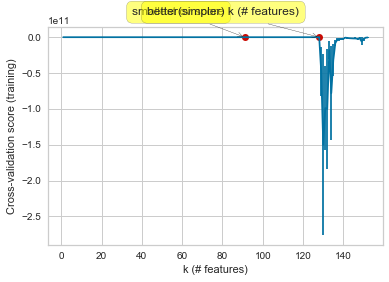

Below as a closer look at the first 150 selections of features


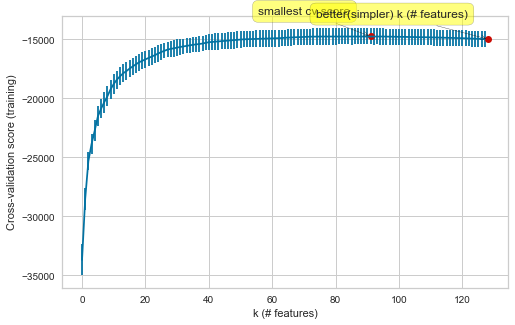




TEST  

Now, test the best model OLS 
(# features selected = 1 out of 305):
Test Accurracy
mse: 1748776108.3230824
r2: 73.9197%

Observation and evaluation:
Compare to OLS on all features, after feature selection via FAR,        
the prediction accuracy R2 was boosted from  68.0272% to 73.919%, by 5.8925%.        
As the feature adding up during the iterativeselection process, the         
prediction shows clear growing of accuracy and reached its best performance        
, i.e. best cv score, at # features = 1.


The features retained by the best model (omit the one-hot effect) are:

{'LowQualFinSF', 'ndFlrSF', 'MasVnrArea', 'MSSubClass', 'SalePrice', 'GrLivArea', 'GarageCars', 'Fireplaces', 'SsnPorch', 'YearBuilt', 'BsmtHalfBath', 'GarageArea', 'HalfBath', 'OpenPorchSF', 'LotFrontage', 'OverallQual', 'BsmtUnfSF', 'OverallCond'}


In [460]:
print ("\n* Due to time constraint, the BSR regression only run until adding up to 152 features, \
\nwhich is ~ half of the total feature number 305. This should be also reasonable as an \
\nincrease in MSE error has been obverseved after adding more features to the model with 90\
\nfeatures selected already.\n")
# Report best k
best_k_f, best_cv_f, min_k_f, min_cv_f = cv_report(cv_fsr, range(1, len(cv_fsr)+1), param="k (# features)", display=True, plot=False, name="FSR ols")
cv_plot(cv_fsr, range(1, len(cv_fsr)+1), param="k (# features)",min_k=min_k_f, min_cv=min_cv_f, best_k=best_k_f, best_cv=best_cv_f)

print ("Below as a closer look at the first 150 selections of features")
cv_plot(cv_fsr[:128], range(128), param="k (# features)", min_k=min_k_f, min_cv=min_cv_f, best_k=best_k_f, best_cv=best_cv_f, word=False, figsize=(8,5))

# Test
print("\n\n\nTEST  \n\nNow, test the best model OLS \n(# features selected = {} out of 305):\n".format(min_k)+"="*65)
fsr = LinearRegression().fit(sfs1.transform(X_train), y_train)
y_pred_f = fsr.predict(sfs1.transform(X_test))
mse, r2 = test_report(y_pred_f, y_test)

print ("Observation and evaluation:")
print ("Compare to OLS on all features, after feature selection via FAR,\
        \nthe prediction accuracy R2 was boosted from  68.0272% to {}%, by {}%.\
        \nAs the feature adding up during the iterativeselection process, the \
        \nprediction shows clear growing of accuracy and reached its best performance\
        \n, i.e. best cv score, at # features = {}.\n\n".format(str(r2*100)[:6],str(r2*100-68.0272)[:6], min_k ))

# analysis what features are retained
picked_fsr_all = [name_space[i] for i in sfs1.subsets_[min_k_f]['feature_idx']]
picked_fsr, picked_fsr_all, dropped_fsr, dropped_fsr_all  = featuer_retain_analysis(data_train.columns.values, name_space, picked_fsr_all)
print ("The features retained by the best model (omit the one-hot effect) are:\n")
print (picked_fsr)


### 5. BSR..

In [340]:
from models.bsrCV import bsrCV

sfs2, cv_, n_f_, features = BSRCV(X_train_frame, name_space)
print ("\nBSR TRAINED.")


BSR TRAINED.



                   CV Score Report (FSR):
k (# features) = 69 has the smallest CV score of:
 mean                std
-750392233.4626458,  143361226.32625347

Among all k (# features) reporting a score within 1 SE of the 
smallest score(-893753459.7888992, -607031007.1363924),
we choose the simplest model as a better model. 

all k (# features) that qualifies
k (# features)    cv score   std
143:  -893005842.745315 | 153714264.77412 |
142:  -892299123.739885 | 153500509.99363 |
141:  -876473911.720791 | 154756471.21393 |
140:  -875552019.329352 | 154445498.69657 |
139:  -871660122.212912 | 154688536.93657 |
138:  -869818873.508477 | 154832191.91437 |
          .............................  
          .............................  

35:  -831092152.429352 | 161971214.01162 |
34:  -844452441.960125 | 167216549.68032 |
33:  -854240029.830614 | 166724569.43449 |
32:  -868868230.097521 | 169850268.46115 |
31:  -879789735.698482 | 165478731.14468 |


We could risk a simpler model, i.e. pic

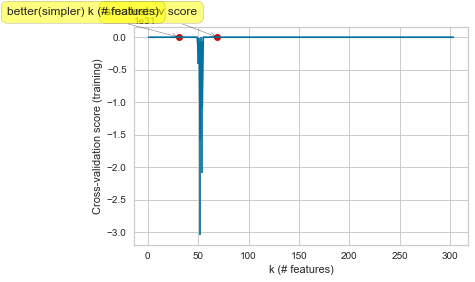

Below as a closer look at the cv scores when dropped 304 features down to 200 features to 30 features


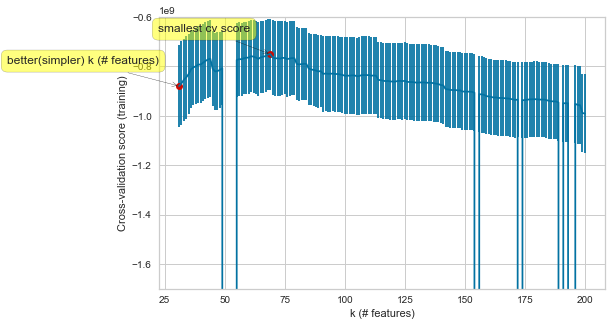

To obtain the smallest cv score at min_k point, the features being retained by BSR are: 

['MSSubClass', 'MSZoning_0', 'MSZoning_1', 'LotArea', 'Neighborhood_0', 'Neighborhood_7', 'Neighborhood_8', 'Neighborhood_12', 'Neighborhood_13', 'Neighborhood_15', 'Neighborhood_16', 'Neighborhood_17', 'Neighborhood_18', 'Neighborhood_22', 'Neighborhood_23', 'Condition1_3', 'Condition1_6', 'Condition2_5', 'Condition2_6', 'BldgType_4', 'HouseStyle_0', 'HouseStyle_4', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofMatl_0', 'RoofMatl_1', 'RoofMatl_3', 'RoofMatl_5', 'Exterior1st_0', 'Exterior1st_4', 'Exterior1st_5', 'Exterior1st_8', 'Exterior2nd_5', 'MasVnrArea', 'ExterQual_1', 'BsmtQual_1', 'BsmtExposure_2', 'BsmtExposure_4', 'BsmtFinSF1', 'TotalBsmtSF', 'Heating_1', 'Heating_5', 'HeatingQC_3', 'CentralAir_0', 'GrLivArea', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual_0', 'KitchenQual_1', 'TotRmsAbvGrd', 'Functional_6', 'Fireplaces', 'FireplaceQu_0', 'GarageFinish_0', 'GarageArea', '

In [1893]:
# Report best k, plot   
best_k_b, best_cv_b, min_k_b, min_cv_b = cv_report(cv_, n_f_, param="k (# features)", display=True, plot=True, name="FSR", forward=False)

print ("Below as a closer look at the cv scores when dropped 304 features down to 200 features to 30 features")
cv_plot(cv_[-200:-30], n_f_[-200:-30], param="k (# features)", min_k=min_k_b, min_cv=min_cv_b, 
        best_k=best_k_b, best_cv=best_cv_b, word=False, 
        figsize=(8,5), y_lim=(-1.7*1e9, -0.6*1e9))

picked_bsr_all = features[min_idx].split("~")[1].split("+")
picked_bsr, picked_bsr_all, dropped_bsr, dropped_bsr_all = featuer_retain_analysis(data_train.columns.values, name_space, picked_bsr_all)
    
print ("To obtain the smallest cv score at min_k point, the features being retained by BSR are: \n".format(len(dropped_all)))
print (picked_bsr_all)

print ("If omit the one-hot effect, the features retained by BSR are in short the list:\n()   (total:{})".formst(dropped_bsr, len(dropped_c)))
# Test
print("\n\n\nNow, test the best model OLS \n(# features selected = {} out of 305):\n".format(min_k_b)+"="*45)

min_idx = n_f_.index(min_k_b)  

sfs = smf.ols(features[min_idx], data=X_train_frame).fit() 
y_pred_b = sfs.predict(X_test_frame[features[min_idx].split("~")[1].split("+")])
mse_b, r2_b = test_report(y_pred_b, y_test)

print ("Observation and evaluation:\n")
print ("Compare to OLS on all features, after feature selection via BSR,\nthe test accuracy was boosted from r2 68.0272% to {}% by {}%. \nIt also outperform FSR which added features recursively by comparing MSE.".format(str(r2_b*100)[:6],str(r2_b*100-68.0272)[:6] ))

 ------------------------------------
## 1(F). Add quadratic features and train ( KNN, Ridge/LASSO, BSR, FSR)

In [186]:
from itertools import combinations

X_train_frame_quad = X_train_frame  # use frame to compute and add quadratic xij
X_test_frame_quad =  X_test_frame

for f_i, f_j in combinations(name_space[1:], 2):  # name_space[0] is constant addded, don't select for multiplication
    X_train_frame_quad[f_i+"/"+f_j] = X_train_frame[f_i] * X_train_frame[f_j]  # add new quadratic xi*xj to train set
    X_test_frame_quad[f_i+"/"+f_j] = X_test_frame[f_i] * X_test_frame[f_j]  # add new quadratic xi*xj to test set

X_train_frame_quad = X_train_frame_quad.drop('y', 1)  # remove the previously added y
    
X_train_q = X_train_frame_quad.values 
X_test_q = X_test_frame_quad.values 

q_n_sample, q_n_fea = X_train_q.shape
q_n_sample_t, q_n_fea_t = X_test_q.shape 
print ("Quadratic feature dataset constructed\ntraining set: {},{}\ntest set: {},{}".format(q_n_sample, q_n_fea, q_n_sample_t, q_n_fea_t))

Quadratic feature dataset constructed
training set: 1168,46361
test set: 292,46361


In [409]:
name = "knn"
scale = range(1,100,2)

# cv_scores_knn_q = knnCV(X_train_q, y_train, scale, cv=10)
best_k_knn_q, __, min_k_knn_q, __ = cv_report(cv_scores_knn_q, scale, "k", name=name,display=False,plot=False)

# test 
knnmodel = KNeighborsClassifier(n_neighbors=min_k_knn_q)
knnmodel.fit(X_train_q, y_train) 
y_pred_knn_q = knnmodel.predict(X_test_q)
print ("training on x + quadratic features xixj, the best lambda is found to be {}".format(min_k))  
print ("\n                  KNN \n        (quadratic feature, k={})".format(min_k))
print ("*"*40)
_, x = test_report(y_pred_knn_q, y_test)

print ("before quadratic and k=3")
_, x0 = test_report(y_pred_knn, y_test)

print ("From empirical results: adding quadratic feature xij boosted r2 by {}%.".format(str((x-x0)*100)[:5]))

training on x + quadratic features xixj, the best lambda is found to be 1

                  KNN 
        (quadratic feature, k=1)
****************************************
Test Accurracy
mse: 3271846513.7636986
r2: 51.2055%

before quadratic and k=3
Test Accurracy
mse: 3462619536.527397
r2: 48.3604%

From empirical results: adding quadratic feature xij boosted r2 by 2.845%.


In [502]:
name="ridge"   

scale = lambds = np.logspace(-1, 3.3, 100)   # 100 lambdas to try

__, scores_r = ridgeCV(X_train_q, y_train, scale) 
best_k_r, best_cv_r, min_k_r, min_cv_r = cv_report(scores_r, x_axis, param = "lambda("+name+")", display=False, plot=False, name=name)
ridgemodel = Ridge(alpha=min_k_r).fit(X_train_q, y_train)
y_pred_ridge_q = ridgemodel.predict(X_test_q)  

print ("training on x + quadratic features xixj, the best lambda is found to be {}".format(min_k_r))    
print ("\n                  RIDGE \n        (quadratic feature, lambda={})".format(min_k_r))
print ("*"*40)
mse, r2 = test_report(y_pred_ridge_q, y_test)

print ("before quadratic and lambda=402.76")  
__, r20 = test_report(y_pred_ridge, y_test)

print ("From empirical results: adding quadratic feature to ridge xij didn't \nimprovede prediction but down-performed by {}%.".format(str(abs(r2-r20)*100)[:5]))

training on x + quadratic features xixj, the best lambda is found to be 0.495392577173869

                  RIDGE 
        (quadratic feature, lambda=0.495392577173869)
****************************************
Test Accurracy
mse: 7344086487.89408
r2: -9.5254%

before quadratic and lambda=402.76
Test Accurracy
mse: 1855244517.3400059
r2: 72.3319%

From empirical results: adding quadratic feature to ridge xij didn't 
improvede prediction but down-performed by 81.85%.


In [500]:
name="lasso"
scale = lambds = np.logspace(-1, 3.3, 100) 

__, scores_l_q = lassoCV(X_train_q, y_train, scale)
best_k_l, best_cv_l, min_k_l, min_cv_l = cv_report(scores_l_q, x_axis, param = "lambda("+name+")", display=False, plot=False, name=name)
print ("done")

lassomodel = Lasso(alpha=min_k_l).fit(X_train_q, y_train)
y_p_lasso_q = lassomodel.predict(X_test_q)  

print ("training on x + quadratic features xixj, the best lambda is found to be {}".format(min_k_l))    
print ("\n                  LASSO \n        (quadratic feature, \nlambda={})".format(min_k_l))
print ("*"*40)
test_report(y_p_lasso_q, y_test)
print ("\n"+"-"*30)
print ("Compared with training on original feature, lambda=600.88")   
test_report(y_pred_lasso, y_test)

done
training on x + quadratic features xixj, the best lambda is found to be 491.94799164082156

                  LASSO 
        (quadratic feature, 
lambda=491.94799164082156)
****************************************
Test Accurracy
mse: 7827670011.444409
r2: -16.737%


------------------------------
Compared with training on original feature, lambda=600.88
Test Accurracy
mse: 1876231356.1545827
r2: 72.0189%



c:\users\celix\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


(1876231356.1545827, 0.7201897151094128)

In [382]:
print ("skip FSR and BSR for quadratic features due to time constraints.")

skip FSR and BSR for quadratic features due to time constraints.


## 1(G). Analyze dropped features by LASSO and stepwise regression

In [614]:
print ("         The following listed the features regularized/retained\n                   by LASSO, BSR and FSR.")
print ("-"*75)
# lasso
print ("\n----------------\n---LASSO---\nregularized away are: \n{}\n".format(dropped_lasso, len(dropped_lasso)))
print ("retained are:\n{}\n({} out 80)".format(picked_lasso, len(picked_lasso)))
print ("-"*55)
# bsr
print ("\n---BSR---\ndropped by BSR are: \n{}\n".format(dropped_bsr, len(dropped_bsr)))
print ("retained are:\n{}\n({} out 80)".format(picked_bsr, len(picked_bsr)))
print ("-"*55)
#fsr
print ("\n---FSR---\ndropped by FSR are: \n{}\n".format(dropped_fsr, len(dropped_fsr)))
print ("retained are:\n{}\n({} out 80)".format(picked_fsr, len(picked_fsr)))
print ("-"*55)

bsr_fsr = set(picked_bsr) - (set(picked_bsr) - set(picked_fsr) )
tmp = set(picked_lasso) - (set(picked_lasso)- set(bsr_fsr))

bsr_fsr_d = set(dropped_bsr) - (set(dropped_bsr) - set(dropped_fsr) )
tmp_d = set(dropped_lasso) - (set(dropped_lasso)- set(bsr_fsr_d))

         The following listed the features regularized/retained
                   by LASSO, BSR and FSR.
---------------------------------------------------------------------------

----------------
---LASSO---
regularized away are: 
{'Alley', 'ExterCond', 'BsmtCond', 'Exterior1st', 'PoolQC', 'CentralAir', 'KitchenAbvGr', 'LotConfig', 'GarageFinish', 'PoolArea', 'SaleType', 'Exterior2nd', 'GarageType', 'Street', 'SaleCondition', 'YrSold', 'LotShape', 'TotalBsmtSF', 'BldgType', 'MasVnrType', 'MiscFeature', 'PavedDrive', 'BsmtQual', 'HeatingQC', 'Electrical', 'MoSold', 'BsmtFinType2', 'HouseStyle', 'WoodDeckSF', 'LandContour', 'BsmtFinSF1', 'stFlrSF', 'MSZoning', 'EnclosedPorch', 'RoofMatl', 'ExterQual', 'LandSlope', 'Condition1', 'Foundation', 'BsmtFullBath', 'Neighborhood', 'ScreenPorch', 'Fence', 'GarageCond', 'Heating', 'BsmtFinType1', 'KitchenQual', 'Condition2', 'OpenPorchSF', 'YearRemodAdd', 'BsmtExposure', 'RoofStyle', 'BsmtFinSF2', 'FireplaceQu', 'Functional', 'constant', 'Gara

In [606]:
print ("\n\n|  The features that are retained by all of the three LASSO, BSR and FSR are |:\n{}\n  {}\n ({} out of 80)".format("-"*90, tmp, len(tmp)))

print ("\n|  The features that are dropped by all of the three LASSO, BSR and FSR are |:\n{}\n  {}\n ({} out of 80)".format("-"*90, tmp_d, len(tmp_d)))


# comared with 1(d) and intuition
print ("\n\nLooking back at the 95% confidence interval grouping in part 1(D).")
print ("The group of features with 95%CI contain 0 are: \n{}\n\n{}\n({} out of 80)".format("- "*30, f1_short, len(f1_short)))

print ("\n\nRelated to 1(d) and intuitions")
print ("-"*50)
print ("")
tmp_d_only = tmp_d - f1_short
print ("Of all the 50 features dropped by all LASSO, BSR and FSR at their best model, {}% of these features\
\nshowed a 95% confidence interval of containing zero in the tentative OLS training in 1(d). \
\nThese features are dropped in the later regularized regression approaches and gave an improvement\
\nin the prediction accuracy (as well as the training time).".format(100 - 100*len(tmp_d_only)/len(tmp_d)))

print ("\nThese statistically \"really-not-important\"(95%CI contain 0 and dropped by three) features are:\n{}\n".format(tmp_d-tmp_d_only))

print ("In terms of intuitions/commonsense, we actually found some of those features classified\
\nas not important as above quite surprising, such as house style, electricity, year sold, which we thought \
\nwould be quite relevant to or would influence a house's selling prices.")

print ("Also, garage area v.s. garage type, the first is retained by all whereas the the second feature\
\nis dismissed by all. This follows the intuition that the area usually determines price versus type. \
\n \nAlso, it is found that features describing more generally about the house are more important than details, e.g.\
\nthe overal quality, overal condition versus. basement exposure, basement height, fence, etc. ")

print ("\n\nMore comments")
print ("-"*50)
print ("\n\nFrom the retained features using FSR, BSR, LASSO, we noticed that the features contains a \
\ncomprehensive aspect of what we can think about when buying a house. There are features about \
\nsizes of rooms, kitchens, common places, garages, basements, and even fireplaces. Also features \
\nabout utilities like type of house, material of roof and exterior, type of heating system, type of\
\nfences, quality and capacity of garage, etc. Other than the house itself, the regressions showed \
\nthat people also concern about the environment around the building such as the building (for apartments), \
\nneighborhood, and road condition around the house. Of course time is also what people concern a lot during\
\ncomparison: year of built, time of sold, and quality when sold. Comparing the features retained from \
\nthe OLS regression in 1(d), we feel like the features are similar among the different approaches. For \
\nexample, after recombining the categorical features, there are 43 feature retained in both BSR and OLS, \
\nand 21 of them are equivalent. The number of features in LASSO is 60, and the number of features of FSR is\n")



|  The features that are retained by all of the three LASSO, BSR and FSR are |:
------------------------------------------------------------------------------------------
  {'MasVnrArea', 'MSSubClass', 'SalePrice', 'GrLivArea', 'YearBuilt', 'Fireplaces', 'GarageArea', 'OverallQual', 'OverallCond'}
 (9 out of 80)

|  The features that are dropped by all of the three LASSO, BSR and FSR are |:
------------------------------------------------------------------------------------------
  {'Alley', 'ExterCond', 'BsmtCond', 'Exterior1st', 'PoolQC', 'CentralAir', 'LotConfig', 'GarageFinish', 'PoolArea', 'SaleType', 'Exterior2nd', 'GarageType', 'Street', 'SaleCondition', 'YrSold', 'LotShape', 'BldgType', 'MasVnrType', 'MiscFeature', 'PavedDrive', 'BsmtQual', 'HeatingQC', 'Electrical', 'BsmtFinType2', 'HouseStyle', 'WoodDeckSF', 'LandContour', 'stFlrSF', 'MSZoning', 'EnclosedPorch', 'RoofMatl', 'ExterQual', 'LandSlope', 'Condition1', 'Foundation', 'BsmtFullBath', 'Neighborhood', 'Fence', 'Garag

-------------------------
## Train the Best Classifier Above on Kaggle

In [779]:
# data preprocessing
all_in = pd.concat([data_train, data_test], axis=0)
all_in.reindex(columns=data_train.columns.values)
data_data, name_space_all = preprocessing(all_in, cat_f)

data_data = sm.add_constant(data_data)    
name_space_all.insert(0, "constant")

train = data_data[:data_train.shape[0]]
test = data_data[data_train.shape[0]:]
print ("have train data: {}".format(train.shape))
print ("have test data: {}".format(test.shape))

have train data: (1460, 312)
have test data: (1459, 312)


In [816]:
import csv
# train ridge model
ridgemodel = Ridge(alpha=min_lambda["ridge"]).fit(train, Y)
label = ridgemodel.predict(test) 
model = Ridge(alpha=min_lambda["lasso"]).fit(X_train, y_train)
hold_out = model.predict(X_test) 

ids = 1461
n_data, n_feature = data_test.shape #(1459, 312)
results = pd.DataFrame({"SalePrice": label.reshape(-1)}, index=[i for i in range(ids, ids+n_data)])
# results.to_csv(path_or_buf="outputs.csv")

print ("The score obtained from *Kaggle is 0.14818")
print ("(the sccore is calculated by Mean Square Log)")

The score obtained from *Kaggle is 0.14818
(the sccore is calculated by Mean Square Log)


In [830]:
from sklearn.metrics import mean_squared_log_error
error_ridge = mean_squared_log_error(y_pred_ridge, y_test)
hold_out_err = mean_squared_log_error(hold_out, y_test)

print ("\nThe real test accuracy: 0.14818 from Kaggle is much higher than the cross validation accuracy {}.".format(str(error_ridge)[:7]))
print ("\nThe reason might due to over-fitting. The model is learned particularly good for train data but not as good when\
\na new set of data, test data. Another reason might also be that the searched best model in part 1(E) with \
\nlambda {} might not be the best for the current test set. Since it was observered that new types \
\nappeared in test set categorical features. So that now the features have expanded from 305 to 312 as shown above, \
\nso the best lambda value might change.".format(min_lambda["ridge"]))

print ("\nIt is also lower than the held-out cross validation accuracy {}. The reason could be also that we overfit\
\nthe training data. ".format(str(hold_out_err)[:7]))


The real test accuracy: 0.14818 from Kaggle is much higher than the cross validation accuracy 0.02331.

The reason might due to over-fitting. The model is learned particularly good for train data but not as good when
a new set of data, test data. Another reason might also be that the searched best model in part 1(E) with 
lambda 402.76386988911156 might not be the best for the current test set. Since it was observered that new types 
appeared in test set categorical features. So that now the features have expanded from 305 to 312 as shown above, 
so the best lambda value might change.

It is also lower than the held-out cross validation accuracy 0.02296. The reason could be also that we overfit
the training data. 
